# Report 2

Note, all of my inner notes have come from Professor Natalie Franks lectures, the professor has taught us how to do SVD and PCA mathematically so all the formulas written have come from my personal lecture notes. I would like to thank Eric Ye for helping me discuss potential methods in developing an algorithm to solve the tasks for this homework assignment.

# Task 1

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score
import plotly.graph_objects as go


filename = "walking_1"
folder = "hw2data/train/"

vals = np.load(folder + filename + ".npy")

print(vals.shape)

xyz = np.reshape( vals[:, :], [38, 3, -1])

print(xyz.shape)


(114, 100)
(38, 3, 100)


In [125]:
folder = "hw2data/train/"
files = os.listdir(folder)

movements = ["jumping", "running", "walking"]

X_train = []
for movement in movements:
    for i in range(1, 6):
        path = os.path.join(folder, movement + "_" + str(i) + ".npy")
        X_train.append(np.load(path))

X_train = np.hstack(X_train)  # (114, 1500)

### Formula for PCA requires centering data

The formula for centering data is:

$$X_{\text{Centered}} = X - \sigma$$

where $\sigma$ is the mean (average) of the dataset


In [126]:
centered_data = X_train - np.mean(X_train, axis=1)[:, None]

## Now we perform SVD

To recall, you can use ```np.linalg.svd``` to find the SVD, and we can manipulate the column vectors of the resulting matrices to do our PCA. Since the eigenvalues of $\sigma$ are the squared singular values of the centered data, PCA can be computed more efficiently using SVD.

In [127]:
U, Sigma, Vt = np.linalg.svd(centered_data)
# (114, 114) (114,) (1500, 1500)

## Now we find the Cumulative Energy

To compute the **cumulative energy**, we sum up the first \( k \) singular values:

$$
E_{\text{cumulative}, k} = \sum_{i=1}^{k} \frac{s_i^2}{\sum_{j} s_j^2}
$$

Where:
- $ s_i^2 $ is the energy contribution of the $ i $-th singular value.
- The denominator normalizes the values so that $E$ represents the **fraction of the total energy contributed by each singular value**.

In Python, this can be computed using:

```python
E_cumulative = np.cumsum(E)  # Compute cumulative sum of normalized energy

Cumulative energy reaches 0.7 at PCA mode: 2
Cumulative energy reaches 0.8 at PCA mode: 3
Cumulative energy reaches 0.9 at PCA mode: 5
Cumulative energy reaches 0.95 at PCA mode: 7


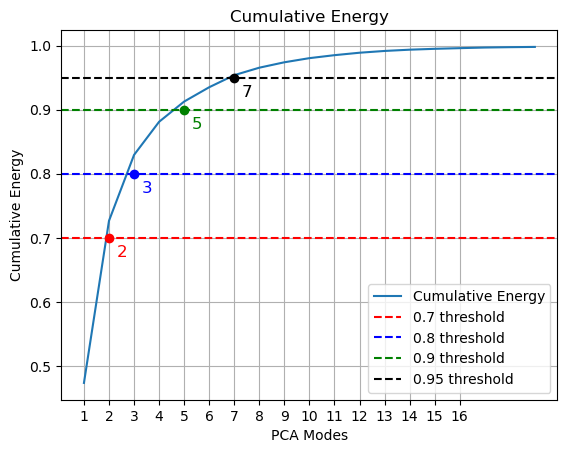

In [128]:
energy = np.power(Sigma, 2)/np.sum(np.power(Sigma, 2))
cumulative_energy = np.cumsum(energy)

thresholds = [0.7, 0.8, 0.9, 0.95]
colors = ["red", "blue", "green", "black"]
intersection_points = {}
for threshold in thresholds:
    idx = np.searchsorted(cumulative_energy, threshold) + 1  # +1 to match PCA mode indexing
    intersection_points[threshold] = idx
    print(f"Cumulative energy reaches {threshold} at PCA mode: {idx}")

plt.figure()
plt.plot(np.arange(1, 20, 1), cumulative_energy[:19], label="Cumulative Energy")

for threshold, color in zip(thresholds, colors):
    idx = intersection_points[threshold]
    plt.axhline(y=threshold, color=color, linestyle="--", label=f"{threshold} threshold")
    plt.scatter(idx, threshold, color=color, zorder=3)
    plt.text(idx + 0.3, threshold - 0.03, f"{idx}", color=color, fontsize=12)

plt.xticks(np.arange(1, 17, 1))
plt.grid(True)
plt.title("Cumulative Energy")
plt.xlabel("PCA Modes")
plt.ylabel("Cumulative Energy")
plt.legend()
plt.show()

## Task 2

In [129]:
pca1 = U[:, 0] @ X_train
pca2 = U[:, 1] @ X_train
pca3 = U[:, 2] @ X_train

pca2.shape

(1500,)

Text(0, 0.5, 'PCA Mode 2')

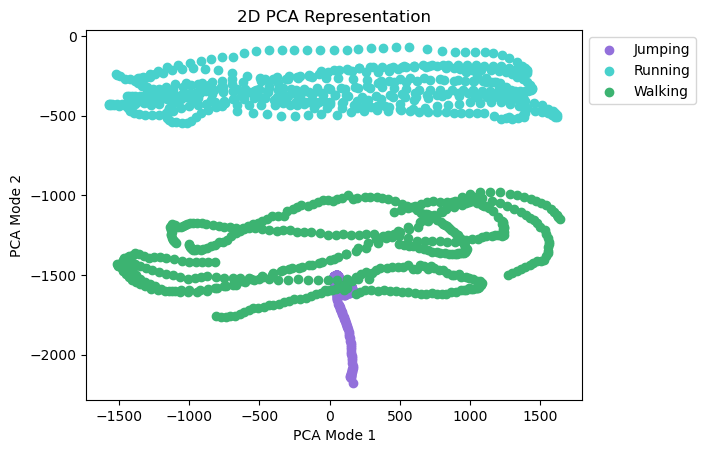

In [130]:

plt.title("2D PCA Representation")
plt.scatter(pca1[:500], -pca2[:500], c="mediumpurple")
plt.scatter(pca1[500:1000], -pca2[500:1000], c="mediumturquoise")
plt.scatter(pca1[1000:], -pca2[1000:], c="mediumseagreen")
plt.legend([movement.capitalize() for movement in movements], loc="upper left", bbox_to_anchor=(1,1))
plt.xlabel("PCA Mode 1")
plt.ylabel("PCA Mode 2")

In [131]:
# Ground Truth

ground_truth = np.hstack((np.full(500, 0), np.full(500, 1), np.full(500, 2)))

# 3D Plot

labels = np.unique(ground_truth)

traces = []
for i in labels:
    mask = ground_truth == i
    trace = go.Scatter3d(
        x=pca1[mask],
        y=pca2[mask],
        z=pca3[mask],
        mode="markers",
        marker=dict(size=2),
        name=movements[i].capitalize()
    )
    traces.append(trace)

layout = go.Layout(
    title="3D PCA Representation",
    scene=dict(
        xaxis=dict(title="PCA Mode 1"),
        yaxis=dict(title="PCA Mode 2"),
        zaxis=dict(title="PCA Mode 3")
    )
)

fig = go.Figure(data=traces, layout=layout)
fig.update_layout(legend=dict(itemsizing='constant', itemwidth=40))

fig.show()

## Task 3

In [132]:
cunulative_pcas = np.vstack([pca1, pca2, pca3])

jump = cunulative_pcas[:, :500]
run = cunulative_pcas[:, 500:1000]
walk = cunulative_pcas[:, 1000:]

movement = [jump, run, walk]
centroids = []
for m in movement:
    centroid = np.mean(m, axis=1)
    centroids.append(centroid)

x_centroid, y_centroid, z_centroid = zip(*centroids)

labels = np.unique(ground_truth)

traces = []
for i in labels:
    mask = ground_truth == i
    trace = go.Scatter3d(
        x=cunulative_pcas[0][mask],
        y=cunulative_pcas[1][mask],
        z=cunulative_pcas[2][mask],
        mode="markers",
        marker=dict(size=2),
        name=movements[i].capitalize()
    )
    traces.append(trace)

center = go.Scatter3d(
    x = x_centroid,
    y = y_centroid,
    z = z_centroid,
    mode = 'markers',
    marker = dict(size=8), name='Centroids', marker_color='black')

traces.append(center)

layout = go.Layout(
    title="3D PCA Representation",
    scene=dict(
        xaxis=dict(title="PCA Mode 1"),
        yaxis=dict(title="PCA Mode 2"),
        zaxis=dict(title="PCA Mode 3")
    )
)

fig = go.Figure(data=traces, layout=layout)
fig.update_layout(legend=dict(itemsizing='constant', itemwidth=40))
fig.show()

## Task 4

In [133]:
results = []

projection = U.T @ centered_data

for i in range(1, 114):

    pca_mode = projection[:i, :]
    jumping, running, walking = np.split(pca_mode, [500, 1000], axis=1)

    centroid_per_movement = np.array([np.mean(m, axis=1) for m in [jumping, running, walking]])

    distances = []
    for centroid in centroid_per_movement:
        distance = np.linalg.norm(pca_mode.T - centroid, axis=1)
        distances.append(distance)
    training = np.argmin(distances, axis=0)

    accuracy = accuracy_score(ground_truth, training)
    results.append(accuracy)

### Note:

Note that the Python command ```np.dot(U.T, U)``` will give you something VERY close to the Identity Matrix

0.9106666666666666


Text(0.5, 1.0, 'Accuracy vs PCA Modes')

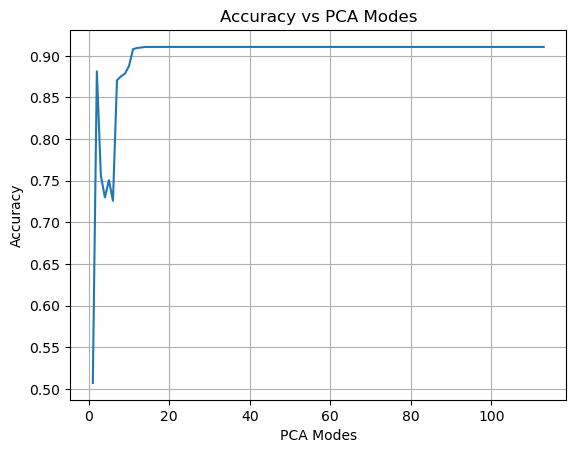

In [139]:
# Plot!

k_mode_t = np.arange(1, 114)
print(results[-1])
plt.plot(k_mode_t, results)
plt.grid(True)
plt.xlabel("PCA Modes")
plt.ylabel("Accuracy")
plt.title("Accuracy vs PCA Modes")

### Zoom in

Text(0.5, 1.0, 'Accuracy vs PCA Modes')

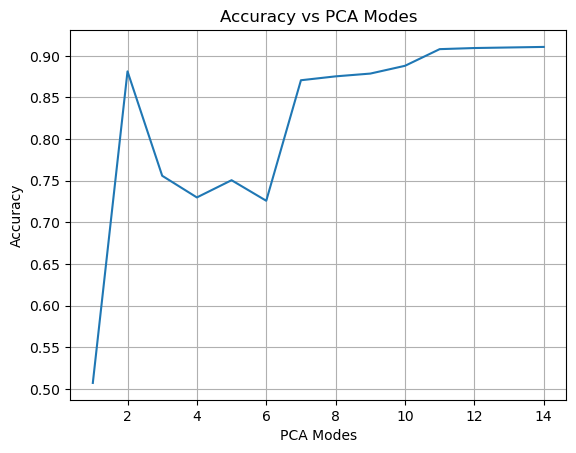

In [135]:
# Plot!

k_mode_t = np.arange(1, 15)

plt.plot(k_mode_t, results[:14])
plt.grid(True)
plt.xlabel("PCA Modes")
plt.ylabel("Accuracy")
plt.title("Accuracy vs PCA Modes")

# Task 5

In [136]:
test_folder = "hw2data/test/"

movements = ["jumping", "running", "walking"]

X_test = []
for movement in movements:
    file_path = os.path.join(test_folder, movement + "_1t.npy")
    X_test.append(np.load(file_path))

X_test = np.hstack(X_test) #(114, 300)
ground_truth_test = np.hstack((np.full(100, 0), np.full(100, 1), np.full(100, 2)))


test_accuracy = []

projection_test = np.dot(U.T, X_train)
pca_test = np.dot(U.T, X_test)

for i in range(1, 114):
    pca_mode = projection_test[:i, :]
    pca_mode_test = pca_test[:i, :]

    jumping, running, walking = np.split(pca_mode, [500, 1000], axis=1)

    centroids = np.array([np.mean(m, axis=1) for m in [jumping, running, walking]])

    distances = []
    for centroid in centroids:
        distance = np.linalg.norm(pca_mode_test.T - centroid, axis=1)
        distances.append(distance)
    
    test = np.argmin(distances, axis=0)

    accuracy = accuracy_score(ground_truth_test, test)
    test_accuracy.append(accuracy)

0.9533333333333334


Text(0.5, 1.0, 'Prediction Analysis')

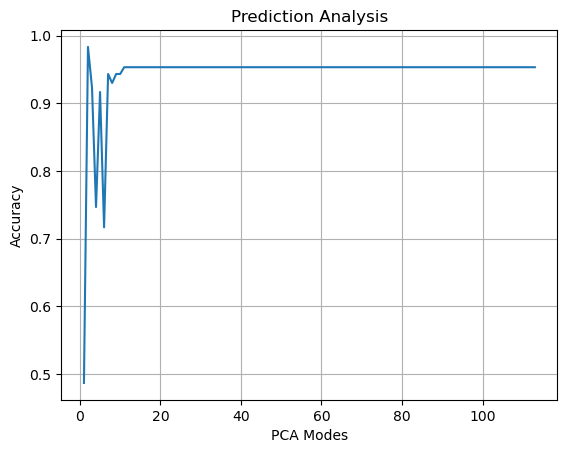

In [140]:
# Plotttttttttt

k_mode_t = np.arange(1, 114)
print(test_accuracy[-1])
plt.plot(k_mode_t, test_accuracy)
plt.grid(True)
plt.xlabel("PCA Modes")
plt.ylabel("Accuracy")
plt.title("Prediction Analysis")

## Let's plot for the Modes that we need

PCA mode Accuracy for 2 modes: 0.9833333333333333
PCA mode Accuracy for 3 modes: 0.9233333333333333
PCA mode Accuracy for 5 modes: 0.9166666666666666
PCA mode Accuracy for 7 modes: 0.9433333333333334


Text(0.5, 1.0, 'Prediction Analysis')

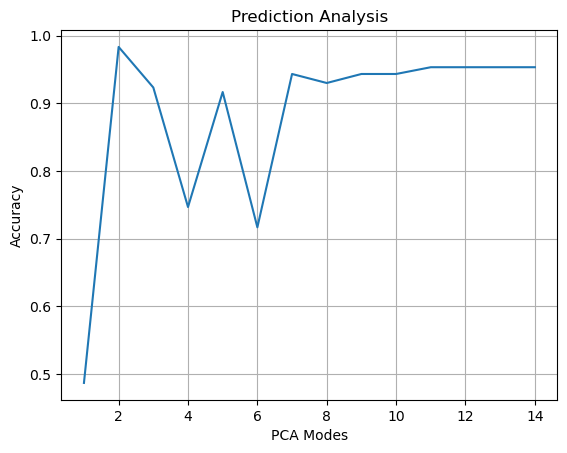

In [138]:
modes = [2, 3, 5, 7]
for mode in modes:
    print(f"PCA mode Accuracy for {mode} modes: {test_accuracy[mode-1]}")

x_axis = np.arange(1, 15)
plt.plot(x_axis, test_accuracy[:14])
plt.grid(True)
plt.xlabel("PCA Modes")
plt.ylabel("Accuracy")
plt.title("Prediction Analysis")